In [ ]:
## WARNING!! Do not run all, as some test code blocks have been archived.

# K-Means

In [ ]:
# Essential Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import normalize

In [ ]:
# Pre-requisites for downloading

# Make sure these are installed to load the dataset!!!
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# NOTE: The kaggle.json file should be supplied in addition to this notebook.
# (It contains Sandesh's API Key for Kaggle to load the dataset)

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Download the dataset from Kaggle (5.20 GB!)
# Highly recommend to run in Google Colab to save space on your local machine
!kaggle datasets download kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [02:20<00:00, 47.3MB/s]
100% 5.20G/5.20G [02:20<00:00, 39.8MB/s]


In [ ]:
# Extract Files
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
df2 = pd.read_csv('hmnist_28_28_L.csv')
df2.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2


In [ ]:
#creating label df for each lesion
df_label = df2['label']
df_label.head()

0    2
1    2
2    2
3    2
4    2
Name: label, dtype: int64

In [ ]:
#each label corresponds to a type of lesion. 7 unique values means 7 types of lesions. 
df_label.unique()

array([2, 4, 3, 6, 5, 1, 0])

In [ ]:
#getting rid of labels from df2
df2 = df2.drop(columns = ['label'])
df1 = df2 #Keep df1 for PCA
df2.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0774,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783
0,169,171,170,177,181,182,181,185,194,192,...,176,184,186,185,180,157,140,140,159,165
1,19,57,105,140,149,148,144,155,170,170,...,181,172,175,160,144,114,89,47,18,18
2,155,163,161,167,167,172,155,152,165,175,...,162,163,178,157,166,167,148,141,136,115
3,25,71,116,139,136,153,148,161,172,162,...,142,125,135,138,137,111,71,32,16,16
4,129,162,181,196,205,208,205,213,225,224,...,211,210,197,172,190,195,193,181,147,88


In [ ]:
#turning df2 into numpy array for use with kmeans
df2_old = df2
df2 = df2.to_numpy()

In [ ]:
# These are functions imported previously from our homeworks to calculate K-Means
def calcSqDistances(x, k_mus):
    # Initialise the distances array
    distances = np.zeros((x.shape[0], k_mus.shape[0]))
    # Loop over the number of clusters
    for i in range(k_mus.shape[0]):
        # Calculate the euclidean distance between each data point and each mean
        distances[:,i] = np.linalg.norm(x - k_mus[i], axis = 1)
    # Return the distances array
    return distances
def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis = 1)
    return np.eye(sqDmat.shape[1])[m]
def recalcMus(X, Rnk):
    return(np.divide(X.T.dot(Rnk), np.sum(Rnk, axis=0))).T
def runKMeans(df, K):
    X = df
    N = np.shape(X)[0]
    D = np.shape(X)[1]

    #determine and store data set information

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D), dtype=np.float64)

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector
        
        

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)
        

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        
        time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            print(iter)
            break

    return Kmus

In [ ]:
#k = 7 because 7 types of lesions
kmus7 = runKMeans(df2,7)

31


In [ ]:
# Generate cluster plot (from previous assignment)
def get_cluster_plot(Kmus, rows=2): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(28,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

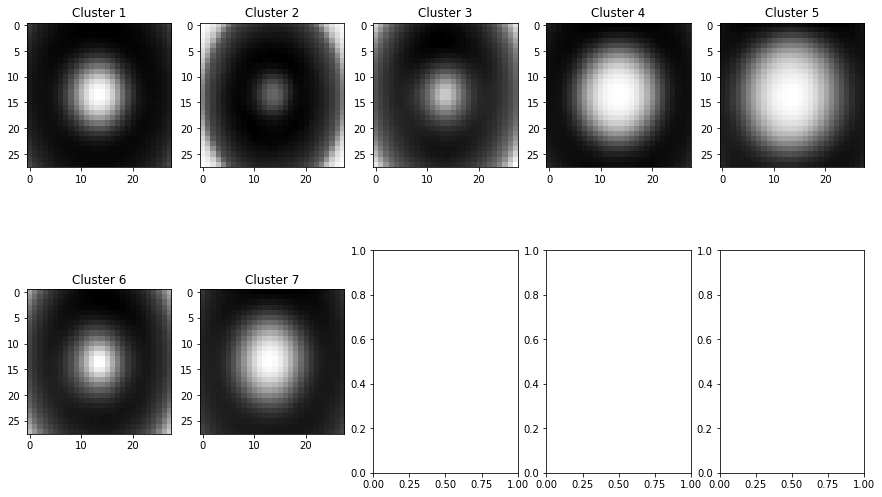

In [ ]:
get_cluster_plot(kmus7)

#PCA

Note: The following code was originally used in Homework 5 and was adapted to fit this project.

In [ ]:
# [Vsort,Dsort] = eigsort(V, eigvals)
#
# Sorts a matrix eigenvectors and a array of eigenvalues in order 
# of eigenvalue size, largest eigenvalue first and smallest eigenvalue
# last.
#
# Example usage:
# di, V = np.linarg.eig(L)
# Vnew, Dnew = eigsort(V, di)
#
# Tim Marks 2002
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort



# viewcolumn(columnvector);
# VIEWCOLUMN Displays a 60 x 60 grayscale image stored in a column vector.
# Tim Marks 2002
def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape([28, 28], order='F'), cmap=plt.get_cmap('gray'))



# normc(M) normalizes the columns of M to a length of 1.
def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

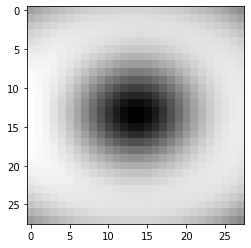

In [ ]:
#turing df1 into numpy array
df1 = df1.to_numpy()
df1 = df1.T

#Calculate mean image
mean = np.mean(df1, axis=1)
mean = mean.reshape((len(mean), 1))
viewcolumn(mean)

In [ ]:
#Calculate eigenvalues
A = np.subtract(df1, mean)
eigen = np.linalg.eig(A.T @ A)
V, D = eigsort(eigen[1], eigen[0])
U = A @ V
U = normc(U)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


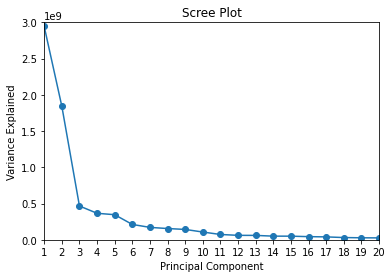

In [ ]:
#Plot principal components
plt.plot(range(1, len(D)+1), D.diagonal(), 'o-')
plt.axis([1, 20, 0, 3000000000])
plt.xticks(np.arange(1, 21, step=1))
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## Reconstructing the 70th image

### Original Image

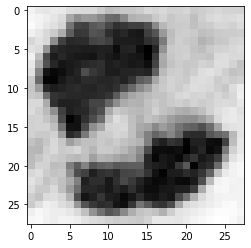

In [ ]:
viewcolumn(df1[:,69])

In [ ]:
#Calculate principal component coordinates
x = np.array(df1[:,69][:,None])
c = U.T @ (x-mean)

### Using 4 Principal Components

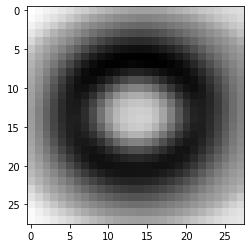

In [ ]:
U_red = U[:,:4]
z_red = U_red @ U_red.T @ (x-mean) + mean
viewcolumn(z_red)

### Using 8 Principal Components

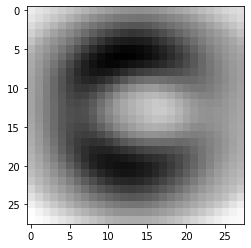

In [ ]:
U_red = U[:,:8]
z_red = U_red @ U_red.T @ (x-mean) + mean
viewcolumn(z_red)

### Using 14 Principal Components

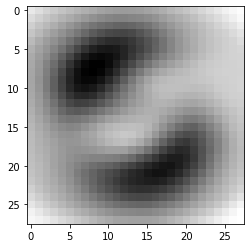

In [ ]:
U_red = U[:,:14]
z_red = U_red @ U_red.T @ (x-mean) + mean
viewcolumn(z_red)

### Using 20 Principal Components

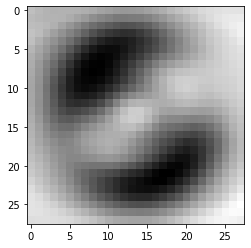

In [ ]:
U_red = U[:,:20]
z_red = U_red @ U_red.T @ (x-mean) + mean
viewcolumn(z_red)

## Reconstructing the 101st image

### Original image

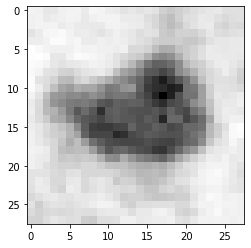

In [ ]:
viewcolumn(df1[:,100])

In [ ]:
#Calculate principal component coordinates
x_1 = np.array(df1[:,100][:,None])
c = U.T @ (x_1-mean)

### Using 4 Principal Components

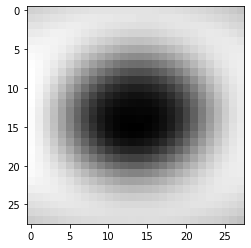

In [ ]:
U_red = U[:,:4]
z_red = U_red @ U_red.T @ (x_1-mean) + mean
viewcolumn(z_red)

### Using 8 Principal Components

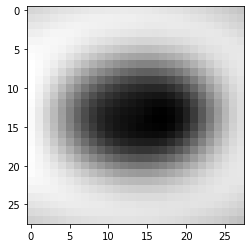

In [ ]:
U_red = U[:,:8]
z_red = U_red @ U_red.T @ (x_1-mean) + mean
viewcolumn(z_red)

### Using 14 Principal Components

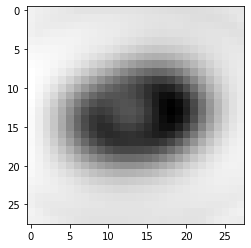

In [ ]:
U_red = U[:,:14]
z_red = U_red @ U_red.T @ (x_1-mean) + mean
viewcolumn(z_red)

### Using 20 Principal Components

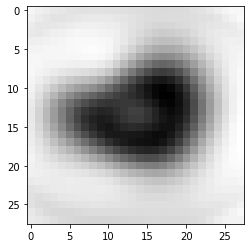

In [ ]:
U_red = U[:,:20]
z_red = U_red @ U_red.T @ (x_1-mean) + mean
viewcolumn(z_red)

# The Graveyard
Here lies some of the code that we attempted to incorporate but were unsuccessful in doing so. (mostly trying to downsample and manually clean/process the source data)

In [ ]:
# Imports
import tensorflow
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

import cv2 as cv
import numpy as np
import os 

from keras.preprocessing.image_dataset import load_image
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from PIL import Image
import os

In [ ]:
# Source dataset image
import PIL as PIL
image = PIL.Image.open('ham10000_images_part_2/ISIC_0029325.jpg')
width, height = image.size
print (width, height)

In [ ]:
#convert images to gray
from PIL import Image
import numpy as np
def convert_to_gray(folder):
    for filename in os.listdir(folder):
        # image = np.asarray(Image.open('/content/HAM10000_images_part_1/'+filename)) /255
        # cv.imwrite(folder+filename, image)
        img = cv.imread(folder+filename)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        cv.imwrite(folder+filename, gray)
        

convert_to_gray('/content/HAM10000_images_part_1/')
# convert_to_gray('/content/HAM10000_images_part_2/')

In [ ]:
# import lodgepole.image_tools as lit
# gray_img = lit.rgb2gray(color_img)
# !zip -r /content/HAM10000_images_part_1.zip /content/HAM10000_images_part_1/
# !zip -r /content/HAM10000_images_part_2.zip /content/HAM10000_images_part_2/

# from google.colab import files
# files.download("/content/HAM10000_images_part_1.zip")
# files.download("/content/HAM10000_images_part_2.zip")

In [ ]:

# downsample all images due to ram constraints
images = []

image_dir = "/content/HAM10000_images_part_1"

filenames = os.listdir(image_dir)
if not os.path.exists(image_dir + '-downsampled'):
    os.makedirs(image_dir + '-downsampled')
for fn in filenames:
    if 'jpg' in fn:
        image_path = os.path.join(image_dir, fn)
        image = cv.imread(image_path)
        for i in range(2):
            image = cv.pyrDown(image)  
        twodim = image[:,:,0]   
        images.append(twodim)
        # out_path = os.path.join(image_dir + '-downsampled', fn)
        # cv.imwrite(out_path, twodeeznuts)

In [ ]:
# use metadata???
import pandas as pd
df1 = pd.read_csv('HAM10000_metadata.csv')
df1.head()

In [ ]:
def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape([28, 28], order='F'), cmap=plt.get_cmap('gray'))
viewcolumn(df2_old[:,40])

In [ ]:
images.shape